<a href="https://colab.research.google.com/github/shantanu2383/Post-Earnings-Announcement-Drfift/blob/main/Post_Earnings_Announcement_Drift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***POST EARNINGS ANNOUNCEMENT DRIFT***

In [ ]:
import pandas as pd
import statsmodels.formula.api as smf 
import numpy as np 
import matplotlib.pyplot as plt

!pip install pandasql
import os
from datetime import datetime
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA 
from sklearn.metrics import mean_squared_error, mean_absolute_error 

import math
import matplotlib.pyplot as plt 
from datetime import datetime
import seaborn as sns 
import pandasql as ps

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26787 sha256=5d6f31db52bb1445b734a3ad9f958ef966450b376a14c255585159c6fd6e19f0
  Stored in directory: /root/.cache/pip/wheels/ed/8f/46/a383923333728744f01ba24adbd8e364f2cb9470a8b8e5b9ff
Successfully built pandasql


In [ ]:
from sqlite3 import connect
conn=connect(':memory:')

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
filepath="/content/gdrive/MyDrive/"

# IMPORT AND CLEAN CRSP DATA

In [ ]:
file=filepath + "CRSPDaily2015to20220331.csv"
columns=['TICKER', 'date', 'SHRCD', 'EXCHCD', 'RET']
crsp_15_22=pd.read_csv(file, usecols=columns)[columns]
print(crsp_15_22)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (49) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


         TICKER      date  SHRCD  EXCHCD        RET
0          EGAS  20150102   11.0     2.0   0.000000
1          EGAS  20150105   11.0     2.0   0.000000
2          EGAS  20150106   11.0     2.0  -0.010889
3          EGAS  20150107   11.0     2.0   0.001835
4          EGAS  20150108   11.0     2.0   0.005494
...         ...       ...    ...     ...        ...
13967877   TSLA  20220325   11.0     3.0  -0.003235
13967878   TSLA  20220328   11.0     3.0   0.080345
13967879   TSLA  20220329   11.0     3.0    0.00708
13967880   TSLA  20220330   11.0     3.0  -0.005075
13967881   TSLA  20220331   11.0     3.0  -0.014982

[13967882 rows x 5 columns]


In [ ]:
#Clean CRSP Data


#Rename columns
crsp_15_22.columns=['tic', 'date', 'shrcd', 'exchcd', 'ret']

#Convert variables
crsp_15_22['tic']=crsp_15_22['tic'].apply(str)
crsp_15_22['date']=pd.to_datetime(crsp_15_22['date'], format="%Y%m%d")

x=['shrcd', 'exchcd', 'ret']
for x in x:
  crsp_15_22[x]=pd.to_numeric(crsp_15_22[x], errors='coerce')



In [ ]:
#only keep dates after 2019
crsp_19_22=crsp_15_22[crsp_15_22['date'] >= "2019-01-01"]

#Only keep US based common stocks
crsp_19_22=crsp_19_22[(crsp_19_22['shrcd']==10) | (crsp_19_22['shrcd']==11)]

#Only keep NYSE/AMEX exchanges
crsp_19_22=crsp_19_22[(crsp_19_22['exchcd']==1) | (crsp_19_22['exchcd']==31) | (crsp_19_22['exchcd']==2)| (crsp_19_22['exchcd']==32)]

#Only keep firms with at least 4 quarters (252 trading days) 
crsp_19_22=crsp_19_22.groupby('tic').filter(lambda x: len(x) >= 252)
'''
The filter method is being called on the DataFrameGroupBy object, and it takes a function as its argument. 
This function takes a group as input and returns a boolean value indicating whether the group should be retained or not. 
In this case, the function returns True if the group has more than 252 rows, and False otherwise. 
The filter method will then return a new DataFrame with only the rows from the groups that returned 
True when passed to the function.
'''

#sort df
crsp_19_22=crsp_19_22.sort_values(by=['tic', 'date'], ascending=True)

#Drop missing/infinite values
crsp_19_22.replace([np.inf, -np.inf], np.nan, inplace=True)
crsp_19_22=crsp_19_22.dropna()

#ReIndex
crsp_19_22=crsp_19_22.reset_index()
crsp_19_22.drop('index', inplace=True, axis=1)

print(crsp_19_22)

         tic       date  shrcd  exchcd       ret
0          A 2019-01-02   11.0     1.0 -0.026238
1          A 2019-01-03   11.0     1.0 -0.036840
2          A 2019-01-04   11.0     1.0  0.034614
3          A 2019-01-07   11.0     1.0  0.021234
4          A 2019-01-08   11.0     1.0  0.014660
...      ...        ...    ...     ...       ...
1121427  ZUO 2022-03-25   11.0     1.0 -0.026025
1121428  ZUO 2022-03-28   11.0     1.0  0.008016
1121429  ZUO 2022-03-29   11.0     1.0  0.029158
1121430  ZUO 2022-03-30   11.0     1.0 -0.037347
1121431  ZUO 2022-03-31   11.0     1.0  0.002007

[1121432 rows x 5 columns]


In [ ]:
crsp_19_22

,tic,date,shrcd,exchcd,ret
0,A,2019-01-02,11.0,1.0,-0.026238
1,A,2019-01-03,11.0,1.0,-0.036840
2,A,2019-01-04,11.0,1.0,0.034614
3,A,2019-01-07,11.0,1.0,0.021234
4,A,2019-01-08,11.0,1.0,0.014660
...,...,...,...,...,...
1121427,ZUO,2022-03-25,11.0,1.0,-0.026025
1121428,ZUO,2022-03-28,11.0,1.0,0.008016
1121429,ZUO,2022-03-29,11.0,1.0,0.029158
1121430,ZUO,2022-03-30,11.0,1.0,-0.037347


# IMPORT AND CLEAN COMPUSTAT DATA

In [ ]:
#Import Compustat Data

file=filepath + "Compustat2018Through2022.csv"
cs_18_22=pd.read_csv(file)

print(cs_18_22)

In [ ]:
#parse relevant variables

cs_18_22=cs_18_22.filter(['tic', 'datadate', 'fyearq', 'fqtr', 'rdq', 'cshoq', 'prccq'])

#drop missing/infinite values
cs_18_22.replace([np.inf, -np.inf], inplace=True)
cs_18_22=cs_18_22.dropna()

#import variables
x=['datadate', 'rdq']
for x in x:
  cs_18_22[x]=pd.to_datetime(cs_18_22[x], format="%Y%m%d")

y=['fyearq', 'fqtr', 'cshoq', 'prccq']

for y in y:
  cs_18_22[y]=pd.to_numeric(cs_18_22[y], errors='coerce')

#Only take dates after 2019
cs_19_22=cs_18_22[cs_18_22['datadate'] > "2019-01-01"]

#Add Market Value
cs_19_22['market_value']=cs_19_22['cshoq'] * cs_19_22['prccq']

#Sort dataframe
cs_19_22=cs_19_22.sort_values(by=['tic', 'datadate'], ascending=True)

#Drop missing/infinite values
cs_19_22.replace([np.inf, -np.inf], np.nan, inplace=True)




In [ ]:
cs_19_22

In [ ]:
print(cs_19_22.head(10))

In [ ]:
#Drop unneeded columns
cs_19_22.drop('cshoq', inplace=True, axis=1)
cs_19_22.drop('prccq', inplace=True, axis=1)

#Reindex
cs_19_22=cs_19_22.reset_index()
cs_19_22.drop('index', inplace=True, axis=1)
print(cs_19_22)

# MERGE CRSP AND COMPUSTAT DATA

In [ ]:
#Merge Compustat and CRSP Dataframes

#Left Join Dataframes
crsp_19_22.to_sql("crsp_19_22", conn, if_exists='replace')
cs_19_22.to_sql("cs_19_22", conn, if_exists='replace')

query=''' 
        SELECT DISTINCT crsp_19_22.tic, crsp_19_22.date, crsp_19_22.ret,
                        cs_19_22.datadate, cs_19_22.rdq, cs_19_22.market_value
        FROM crsp_19_22
        LEFT JOIN cs_19_22
        ON crsp_19_22.tic=cs_19_22.tic
        AND crsp_19_22.date=cs_19_22.rdq
        '''


main_df=pd.read_sql(query, conn)

#add calendar year column
main_df['date']=pd.to_datetime(main_df['date'])
main_df['year']=main_df['date'].dt.year

#add calendar year column
main_df['qtr']=np.ceil(main_df['date'].dt.month/3) #ceil function returns smallest integer that is smaller than or equal to result

print(main_df)

# ADD SIZE DECILES

In [ ]:
#create new df with only RDQ data

data_on_rdq=main_df.dropna()

#Take first market value of each year for each firm

market_value_year_start=data_on_rdq.groupby(['year', 'tic'], as_index=False)['market_value'].first()

'''
The first function returns the first value in each group. The resulting DataFrame, market_value_year_start, 
will have one row for each unique combination of 'year' and 'tic' values in data_on_rdq, and the 'market_value' 
column will contain the first 'market_value' value for each group. 
'''
market_value_year_start['size_quantile']=market_value_year_start.groupby(['year'])['market_value'].rank(pct=True)
#The resulting 'size_quantile' column will therefore contain the percentile rank of the 'market_value' within each year.

#convert quantiles back to deciles
market_value_year_start['size_decile']=np.ceil(market_value_year_start['size_quantile']*10)

#merge size deciles back into main dataframe
main_df.to_sql("main_df", conn, if_exists='replace')
market_value_year_start.to_sql("market_value_year_start", conn, if_exists='replace')

query= ''' 
          SELECT DISTINCT main_df.tic, main_df.date, main_df.datadate, main_df.year, main_df.qtr,
                          main_df.ret, main_df.rdq, market_value_year_start.size_decile
          FROM main_df
          LEFT JOIN market_value_year_start
          ON main_df.tic=market_value_year_start.tic
          AND main_df.year=market_value_year_start.year
          '''

main_df=pd.read_sql(query, conn)

print(main_df)

# ADD ABNORMAL RETURNS TO MAIN DATAFRAME



In [ ]:
main_df['date']=pd.to_datetime(main_df['date'])
main_df['size_decile']=pd.to_numeric(main_df['size_decile'], errors='coerce')

avg_ret=main_df.groupby(['date', 'size_decile'], as_index=False).apply(lambda x: np.average(x['ret']))
#Groups the main dataframe by date and size decile, then applys lambda function to calculate average return for each unique date-size decile 
#combination. Resulting df has one row for each unique date-size decile and the average returns 

avg_ret.columns=['date', 'size_decile', 'avg_ret']


#merge average returns back into main dataframe
main_df.to_sql("main_df", conn, if_exists='replace')
avg_ret.to_sql("avg_ret", conn, if_exists='replace')

query= ''' 
        SELECT DISTINCT main_df.*, avg_ret.avg_ret
        FROM main_df
        LEFT JOIN avg_ret
        ON main_df.size_decile=avg_ret.size_decile
        AND main_df.date=avg_ret.date
        '''

main_df=pd.read_sql(query, conn)
main_df.drop('index', inplace=True, axis=1)

#calculate abnormal returns
r=['ret', 'avg_ret']
for r in r:
  main_df[r]=pd.to_numeric(main_df[r], errors='coerce')

main_df['abm_ret']=main_df['ret']-main_df['avg_ret']

In [ ]:
print(main_df)

# IMPORT + CLEAN IBES SURPRISE HISTORY DATA

In [ ]:
file=filepath +"IBESSurpriseHistory.csv"
ibes=pd.read_csv(file)
print(ibes)

In [ ]:
print(ibes.columns)

In [ ]:
#Only keep data after 2019
y=['PYEAR', 'PMON']
for y in y:
  ibes[y]=pd.to_numeric(ibes[y], errors='coerce')
ibes=ibes[ibes['PYEAR']>=2019]


#Only keep quarterly data
ibes=ibes[ibes['FISCALP']=="QTR"]

#Only keep earnings per share data
ibes=ibes[ibes['MEASURE']=="EPS"]

#ReIndex
ibes=ibes.reset_index()
ibes.drop('index', inplace=True, axis=1)

#add datadate of each row (last day of that month)
ibes['DAY']=1 #temporary day of month column
ibes['datadate']=pd.to_datetime((10000 * ibes['PYEAR'] + 100 * ibes['PMON'] + ibes['DAY']).apply(str), format="%Y%m%d") #initially set to 1st of that month
ibes['datadate']=pd.to_datetime((10000 * ibes['PYEAR'] + 100 * ibes['PMON'] + ibes['datadate'].dt.days_in_month).apply(str), format="%Y%m%d") #set to last day of month

print(ibes.datadate)


In [ ]:
#parse relevant columns
ibes=ibes.filter(['OFTIC', 'PYEAR', 'PMON', 'suescore', 'datadate'])
ibes.columns=['tic', 'year', 'month', 'sue', 'datadate']

#drop missing infinite/missing values
ibes.replace([np.inf, -np.inf], np.nan, inplace=True)
ibes=ibes.dropna()

#sort dataframe
ibes=ibes.sort_values(by=['tic', 'datadate'], ascending=True)

#reindex
ibes=ibes.reset_index()
ibes.drop('index', inplace=True, axis=1)

print(ibes)

# MERGE SUE DATA FROM IBES INTO MAIN DATAFRAME

In [ ]:
#LEFT JOIN IBES DATA INTO MAIN DATAFRAME
main_df.to_sql("main_df", conn, if_exists='replace')
ibes.to_sql("ibes", conn, if_exists='replace')

query=''' 
        SELECT DISTINCT main_df.*, ibes.sue
        FROM main_df
        LEFT JOIN ibes
        ON main_df.tic=ibes.tic AND main_df.datadate=ibes.datadate
        '''
main_df=pd.read_sql(query, conn)
main_df.drop('index', inplace=True, axis=1)

print(main_df)


# ADD SUE DECILES DATA FROM THE PRIOR QUARTER

In [ ]:
#ADD SUE DECILES DATA FROM THE PRIOR QUARTER

#filter for only data on rdq
data_on_rdq=main_df.dropna()

#take unique year and quarter to decrease runtime
data_on_rdq.to_sql("data_on_rdq", conn, if_exists='replace')

query=''' 
        SELECT DISTINCT year, qtr
        FROM data_on_rdq
        '''

sue_deciles=pd.read_sql(query, conn)

#generate new dataframe with quartiles of each year
for i in range(1, 10):
  current_decile=data_on_rdq.groupby(['year', 'qtr'])['sue'].quantile(i/10)
  sue_deciles['prior_quarter_sue_decile' + str(i)]=""
  for j in sue_deciles.index:
    sue_deciles['prior_quarter_sue_decile' + str(i)][j]=current_decile[sue_deciles['year'][j], sue_deciles['qtr'][j]]
  sue_deciles['prior_quarter_sue_decile' + str(i)]=sue_deciles['prior_quarter_sue_decile' + str(i)].shift(1)
  sue_deciles['prior_quarter_sue_decile'+ str(i)]=pd.to_numeric(sue_deciles['prior_quarter_sue_decile' + str(i)], errors='coerce')   
  
  
'''
We create a new data frame called "sue deciles" and add 10 columns to it
We then loop over every row in this dataframe and retrive the values from the current decile based on year and quarter in the sue
decile
We then shift the values we created by one column and convert to numeric
'''                                                                                                

In [ ]:
print(sue_deciles)

In [ ]:
print(data_on_rdq.columns)

In [ ]:
#Merge SUE quantiles

data_on_rdq.to_sql("d", conn, if_exists='replace')
sue_deciles.to_sql("s", conn, if_exists='replace')


query=''' 
      SELECT DISTINCT data_on_rdq.*, sue_deciles.prior_quarter_sue_decile1, sue_deciles.prior_quarter_sue_decile2, sue_deciles.prior_quarter_sue_decile3,
      sue_deciles.prior_quarter_sue_decile4, sue_deciles.prior_quarter_sue_decile5, sue_deciles.prior_quarter_sue_decile6, sue_deciles.prior_quarter_sue_decile7,
      sue_deciles.prior_quarter_sue_decile8, sue_deciles.prior_quarter_sue_decile9
      FROM d data_on_rdq
      LEFT JOIN s sue_deciles
      ON data_on_rdq.year=sue_deciles.year
      AND data_on_rdq.qtr=sue_deciles.qtr
      '''
data_on_rdq=pd.read_sql(query, conn)

#Drop Index Columns
data_on_rdq.drop('index', inplace=True, axis=1)

#Drop first quarter data of every firm (null SUE prior quarter)
data_on_rdq=data_on_rdq.dropna()

#Drop 2nd quarter of overall data (2019q2 due to insufficient sample size in 2019Q1 to rank SUE)

data_on_rdq=data_on_rdq[(data_on_rdq['year'] != 2019) | (data_on_rdq['qtr']!=2)]

#Reindex
data_on_rdq=data_on_rdq.reset_index()
data_on_rdq.drop('index', inplace=True, axis=1)

In [ ]:
print(data_on_rdq.columns)


In [ ]:
data_on_rdq

In [ ]:
#assign each row to corresponding SUE deciles

data_on_rdq['sue_decile']=""
data_on_rdq['sue']=pd.to_numeric(data_on_rdq['sue'], errors='coerce')

for i in data_on_rdq.index:
  if data_on_rdq['sue'][i] <= data_on_rdq['prior_quarter_sue_decile1'][i]:
    data_on_rdq['sue_decile'][i]= 1
  elif data_on_rdq['prior_quarter_sue_decile1'][i] < data_on_rdq['sue'][i] <= data_on_rdq['prior_quarter_sue_decile2'][i]:
    data_on_rdq['sue_decile'][i]=2
  elif data_on_rdq['prior_quarter_sue_decile2'][i] < data_on_rdq['sue'][i] <= data_on_rdq['prior_quarter_sue_decile3'][i]:
    data_on_rdq['sue_decile'][i]=3
  elif data_on_rdq['prior_quarter_sue_decile3'][i] < data_on_rdq['sue'][i] <= data_on_rdq['prior_quarter_sue_decile4'][i]:
    data_on_rdq['sue_decile'][i]=4
  elif data_on_rdq['prior_quarter_sue_decile4'][i] < data_on_rdq['sue'][i] <= data_on_rdq['prior_quarter_sue_decile5'][i]:
    data_on_rdq['sue_decile'][i]=5
  elif data_on_rdq['prior_quarter_sue_decile5'][i] < data_on_rdq['sue'][i] <= data_on_rdq['prior_quarter_sue_decile6'][i]:
    data_on_rdq['sue_decile'][i]=6
  elif data_on_rdq['prior_quarter_sue_decile6'][i] < data_on_rdq['sue'][i] <= data_on_rdq['prior_quarter_sue_decile7'][i]:
    data_on_rdq['sue_decile'][i]=7
  elif data_on_rdq['prior_quarter_sue_decile7'][i] < data_on_rdq['sue'][i] <= data_on_rdq['prior_quarter_sue_decile8'][i]:
    data_on_rdq['sue_decile'][i]=8
  elif data_on_rdq['prior_quarter_sue_decile8'][i] < data_on_rdq['sue'][i] <= data_on_rdq['prior_quarter_sue_decile9'][i]:
    data_on_rdq['sue_decile'][i]=9
  elif data_on_rdq['sue'][i]>data_on_rdq['prior_quarter_sue_decile9'][i]:
    data_on_rdq['sue_decile'][i]=10
  else:
    print("error at row" +str(i))
    break

#drop decile values
todrop=[]

for i in range (1, 10):
  todrop.append('prior_quarter_sue_decile' + str(i))

data_on_rdq.drop(todrop, inplace=True, axis=1)
  

In [ ]:
#Merge SUE decile data with main df

main_df.to_sql("main_df", conn, if_exists='replace')
data_on_rdq.to_sql("data_on_rdq", conn, if_exists='replace')

query='''
        SELECT DISTINCT main_df.*, data_on_rdq.sue_decile
        FROM main_df
        LEFT JOIN data_on_rdq
        ON main_df.tic=data_on_rdq.tic
        AND main_df.year=data_on_rdq.year
        AND main_df.qtr=data_on_rdq.qtr
        '''

main_df=pd.read_sql(query, conn)

#Drop index columns
main_df.drop('index', inplace=True, axis=1)

#convert variable

d=['date', 'datadate', 'rdq']
for d in d:
  main_df[d]=pd.to_datetime(main_df[d], errors='coerce')

main_df['tic']=main_df['tic'].apply(str)

#only keep one row of data per tic and date
main_df=main_df.groupby(['tic', 'date'], as_index=False)
main_df=main_df.first() #selects first row from each group

### DATA CLEANING COMPLETE

# CALCULATE CAR FOR ALL FIRMS

In [ ]:
#STORE DF for future uses

cleaned_df=main_df

#gen new dataframe with tic, SUE decile and size decile on RDQ

tic_of_rdq=main_df.dropna()
tic_of_rdq=tic_of_rdq.filter(['tic', 'sue_decile', 'size_decile'])

#Generate new groupby variable of abnormal return with tic and original index as indices

abn_ret=main_df.reset_index()#generate new index to pop original one out as 'index'
abn_ret.columns=['original_index', 'tic', 'date', 'datadate', 'year', 'qtr', 'ret', 'rdq', 'size_decile', 'avg_ret', 'abn_ret', 'sue', 'sue_decile']
#rename index to original index

abn_ret=abn_ret.groupby(['tic', 'original_index'], as_index=False)['abn_ret'].first() #group by tic and original_index and make them the new indices
abn_ret['new_index']=abn_ret['tic'].apply(str) + "/" + abn_ret['original_index'].apply(str)
abn_ret=abn_ret.set_index('new_index')

#create new array to store CAR around RDQ

car_array_beforeall=[]
car_array_afterall=[]

for i in range(11):
  car_array_beforeall.append([])
  car_array_afterall.append([])







In [ ]:
tic_of_rdq

In [ ]:
n=60

for rdqdate in tic_of_rdq.index:
  #generate indiced for abnormal returns dataframe
  ndaysbeforeindex=str(tic_of_rdq['tic'][rdqdate]) + "/" + str(rdqdate-n)
  rdqdateindex=str(tic_of_rdq['tic'][rdqdate]) + "/" + str(rdqdate)
  ndaysafterindex=str(tic_of_rdq['tic'][rdqdate]) + "/" + str(rdqdate + n)
  if (ndaysbeforeindex in abn_ret.index) and (ndaysafterindex in abn_ret.index):
    #add n days before CAR
    beforeDF=pd.DataFrame(abn_ret.loc[ndaysbeforeindex : rdqdateindex]).reset_index()
    beforeDF['car']=beforeDF['abn_ret'].cumsum()-beforeDF['abn_ret'][0] #calculate car (sum of all abn_ret -first abn_ret)
    car_array_beforeall[tic_of_rdq['sue_decile'][rdqdate].astype(int)].append(beforeDF['car'])
    #add n days after CAR
    afterDF=pd.DataFrame(abn_ret.loc[rdqdateindex : ndaysafterindex]).reset_index()
    afterDF['car']=afterDF['abn_ret'].cumsum()-afterDF['abn_ret'][0] #calculate car (sum of all abn_ret -first abn_ret)
    car_array_afterall[tic_of_rdq['sue_decile'][rdqdate].astype(int)].append(afterDF['car'])

In [ ]:
print(beforeDF)

In [ ]:
'''
The above code does the following:
1. Create 3 strings which can be used to reference the index in abn_ret column
2. Check if 'ndaysbefore' and 'ndaysafter' are in the index of abn_ret
3. If 2 is satisfied:

. Create a new df (beforeDF) and selects rows from abn_ret with index values
 between 'ndaysbefore' and 'rdqdateindex' (and reset index)
. Create a new column in df called 'car' which = cumulative sum of 'abn_ret" column minus first value of abn_ret column
.Append this beforeDF['car'] value to the appropriate list in 'car_array_beforeall' 
 using the 'sue_decile' column of 'tic_of_rdq' as an index.
'''

# STORE CAR DATA (BEFORE RDQ) IN A NEW ARRAY BY DECILE AND DAY

In [ ]:
#ALL FIRMS: Generate new CAR arrays for each decile and each day

#create new array to store CAR data on each day before RDQ

CAR_all_by_days_before=[] #n days before RDQ
#set up empty array
for i in range(11):
  CAR_all_by_days_before.append([])
  for j in range(61):
    CAR_all_by_days_before[i].append([])

#Add CAR data
for i in range(len(car_array_beforeall)):
  for j in range(len(car_array_beforeall[i])):
    for k in range(len(CAR_all_by_days_before[i])):
      CAR_all_by_days_before[i][k].append(car_array_beforeall[i][j][k])

#create new array to store CAR data on each day after RDQ

CAR_all_by_days_after=[] #n days after RDQ

#set up empty array:
for i in range(11):
  CAR_all_by_days_after.append([])
  for j in range(61):
    CAR_all_by_days_after[i].append([])

#add CAR data
for i in range(len(car_array_afterall)):
  for j in range(len(car_array_afterall[i])):
    for k in range(len(CAR_all_by_days_after[i])):
      CAR_all_by_days_after[i][k].append(car_array_afterall[i][j][k])


# TAKE THE AVG OF EACH DAY TO GET AVG CAR

In [ ]:
##All firms: Generate dataframe with Average CAR for Each Day before RDQ

#New dataframe to store data
avg_CAR_all_before=pd.DataFrame()
for i in range(1,11):
  avg_CAR_all_before['decile_' + str(i)]=100* pd.DataFrame(CAR_all_by_days_before[i]).mean(axis=1)

#Add column to store days relative to RDQ
avg_CAR_all_before=avg_CAR_all_before.reset_index()
avg_CAR_all_before=avg_CAR_all_before.rename(columns={'index': 'days_relative_to_rdq'})

#make days relative to RDQ in range [-60, 0] since data is before RDQ

avg_CAR_all_before['days_relative_to_rdq']=pd.to_numeric(avg_CAR_all_before['days_relative_to_rdq'], errors='coerce')
avg_CAR_all_before['days_relative_to_rdq']-= 60

print(avg_CAR_all_before)

# PLOT CAR BEFORE RDQ FOR ALL FIRMS

In [ ]:
#PLOT GRAPH
y=['decile_1','decile_2','decile_3','decile_4', 'decile_5', 'decile_6', 'decile_7','decile_8', 'decile_9', 'decile_10']
all_firms_before_RDQ=avg_CAR_all_before.plot(x="days_relative_to_rdq", y=y, kind="line", figsize=[20,15], title="Figure 2a: CAR before RDQ for all firms" )

all_firms_before_RDQ.set_xlabel("Event time in trading days relative to earnings announcement day")
all_firms_before_RDQ.set_ylabel("Cumulative Abnormal Returns (%)")

#Save graph to google deive
fig=all_firms_before_RDQ.get_figure()
fig.savefig(filepath + "all_firms_before_RDQ.png")

# REPEAT FOR ALL FIRMS AFTER RDQ

In [ ]:
##All firms: Generate dataframe with Average CAR for Each Day before RDQ

#New dataframe to store data
avg_CAR_all_after=pd.DataFrame()
for i in range(1,11):
  avg_CAR_all_after['decile_' + str(i)]=100* pd.DataFrame(CAR_all_by_days_after[i]).mean(axis=1)

#Add column to store days relative to RDQ
avg_CAR_all_after=avg_CAR_all_after.reset_index()
avg_CAR_all_after=avg_CAR_all_after.rename(columns={'index': 'days_relative_to_rdq'})

#make days relative to RDQ in range [-60, 0] since data is before RDQ

avg_CAR_all_after['days_relative_to_rdq']=pd.to_numeric(avg_CAR_all_after['days_relative_to_rdq'], errors='coerce')
avg_CAR_all_after['days_relative_to_rdq']-= 60

print(avg_CAR_all_after)

In [ ]:
#PLOT GRAPH
y=['decile_1','decile_2','decile_3','decile_4', 'decile_5', 'decile_6', 'decile_7','decile_8', 'decile_9', 'decile_10']
all_firms_after_RDQ=avg_CAR_all_after.plot(x="days_relative_to_rdq", y=y, kind="line", figsize=[20,15], title="Figure 2a: CAR after RDQ for all firms" )

all_firms_after_RDQ.set_xlabel("Event time in trading days relative to earnings announcement day")
all_firms_after_RDQ.set_ylabel("Cumulative Abnormal Returns (%)")

#Save graph to google deive
fig=all_firms_after_RDQ.get_figure()
fig.savefig(filepath + "all_firms_after_RDQ.png")

# REPEAT PROCESS FOR SMALL AND BIG FIRMS

In [ ]:
main_df=cleaned_df

main_df=main_df[main_df['size_decile'] >= 8]

main_df=main_df.reset_index()
main_df.drop('index', inplace=True, axis=1)

In [ ]:
#gen new dataframe with tic, SUE decile and size decile on RDQ

tic_of_rdq=main_df.dropna()
tic_of_rdq=tic_of_rdq.filter(['tic', 'sue_decile', 'size_decile'])

#Generate new groupby variable of abnormal return with tic and original index as indices

abn_ret=main_df.reset_index()#generate new index to pop original one out as 'index'
abn_ret.columns=['original_index', 'tic', 'date', 'datadate', 'year', 'qtr', 'ret', 'rdq', 'size_decile', 'avg_ret', 'abn_ret', 'sue', 'sue_decile']
#rename index to original index

abn_ret=abn_ret.groupby(['tic', 'original_index'], as_index=False)['abn_ret'].first() #group by tic and original_index and make them the new indices
abn_ret['new_index']=abn_ret['tic'].apply(str) + "/" + abn_ret['original_index'].apply(str)
abn_ret=abn_ret.set_index('new_index')

#create new array to store CAR around RDQ

car_array_beforeall=[]
car_array_afterall=[]

for i in range(11):
  car_array_beforeall.append([])
  car_array_afterall.append([])



In [ ]:
n=60

for rdqdate in tic_of_rdq.index:
  #generate indiced for abnormal returns dataframe
  ndaysbeforeindex=str(tic_of_rdq['tic'][rdqdate]) + "/" + str(rdqdate-n)
  rdqdateindex=str(tic_of_rdq['tic'][rdqdate]) + "/" + str(rdqdate)
  ndaysafterindex=str(tic_of_rdq['tic'][rdqdate]) + "/" + str(rdqdate + n)
  if (ndaysbeforeindex in abn_ret.index) and (ndaysafterindex in abn_ret.index):
    #add n days before CAR
    beforeDF=pd.DataFrame(abn_ret.loc[ndaysbeforeindex : rdqdateindex]).reset_index()
    beforeDF['car']=beforeDF['abn_ret'].cumsum()-beforeDF['abn_ret'][0] #calculate car (sum of all abn_ret -first abn_ret)
    car_array_beforeall[tic_of_rdq['sue_decile'][rdqdate].astype(int)].append(beforeDF['car'])
    #add n days after CAR
    afterDF=pd.DataFrame(abn_ret.loc[rdqdateindex : ndaysafterindex]).reset_index()
    afterDF['car']=afterDF['abn_ret'].cumsum()-afterDF['abn_ret'][0] #calculate car (sum of all abn_ret -first abn_ret)
    car_array_afterall[tic_of_rdq['sue_decile'][rdqdate].astype(int)].append(afterDF['car'])

# REPLICATE TABLE 1 FROM BERNARD (1989)

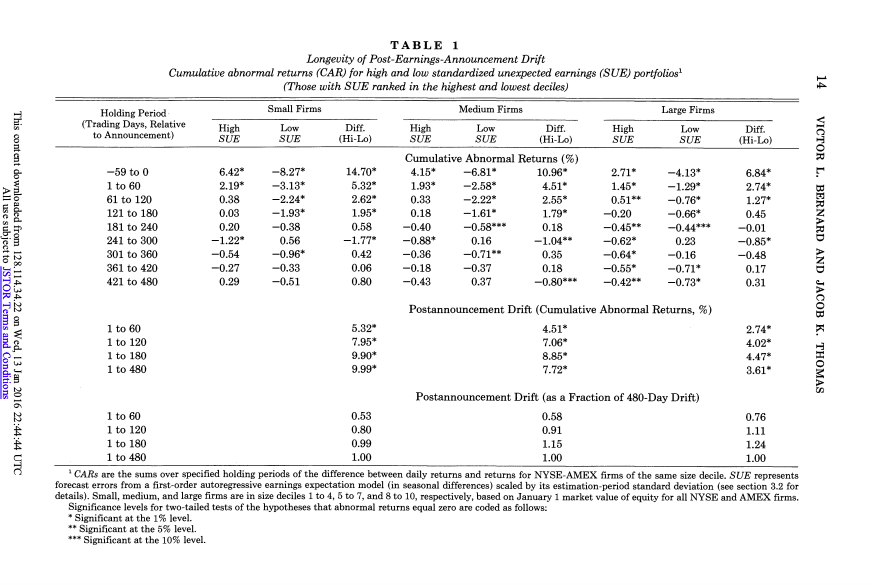

In [ ]:
#For big firms

main_df=cleaned_df

main_df=main_df[main_df['size_decile'] >= 8]

main_df=main_df.reset_index()
main_df.drop('index', inplace=True, axis=1)



#Create RDQ for big firms

#gen new dataframe with tic, SUE decile and size decile on RDQ

tic_of_rdq=main_df.dropna()
tic_of_rdq=tic_of_rdq.filter(['tic', 'sue_decile', 'size_decile'])

#Generate new groupby variable of abnormal return with tic and original index as indices

abn_ret=main_df.reset_index()#generate new index to pop original one out as 'index'
abn_ret.columns=['original_index', 'tic', 'date', 'datadate', 'year', 'qtr', 'ret', 'rdq', 'size_decile', 'avg_ret', 'abn_ret', 'sue', 'sue_decile']
#rename index to original index

abn_ret=abn_ret.groupby(['tic', 'original_index'], as_index=False)['abn_ret'].first() #group by tic and original_index and make them the new indices
abn_ret['new_index']=abn_ret['tic'].apply(str) + "/" + abn_ret['original_index'].apply(str)
abn_ret=abn_ret.set_index('new_index')

tic_of_rdq_big=tic_of_rdq
abn_ret_big=abn_ret

In [ ]:
#Generate CAR for 15 day periods

period_length=15
period_starts_to_analyse= [-59, -44, -29, -14, 1, 16, 31, 46, 61]

#big firms--> High/Low SUE only
tic_of_rdq_big_hl=tic_of_rdq_big[(tic_of_rdq_big['sue_decile']==1) | (tic_of_rdq_big['sue_decile']==10)]
#filtering for only high/low SUE

car_days_after_rdq_big=pd.DataFrame(index=period_starts_to_analyse, columns=[1,10])

for i in car_days_after_rdq_big.index:
  for j in car_days_after_rdq_big.columns:
    car_days_after_rdq_big[j][i]=[]



In [ ]:
car_days_after_rdq_big

In [ ]:
tic_of_rdq_big_hl

In [ ]:
#fill dataframes with arrays of CAR on the last day of the period

for m in car_days_after_rdq_big.index:
  for rdqdate in tic_of_rdq_big_hl.index:
    mdays_after_rdq_start_index=str(tic_of_rdq_big_hl['tic'][rdqdate]) + "/" + str(rdqdate + m)
    mdays_after_rdq_end_index=str(tic_of_rdq_big_hl['tic'][rdqdate]) + "/" + str(rdqdate + m + period_length -1)
    if (mdays_after_rdq_start_index in abn_ret_big.index) and (mdays_after_rdq_end_index in abn_ret_big.index):
      period_df=pd.DataFrame(abn_ret_big.loc[mdays_after_rdq_start_index : mdays_after_rdq_end_index ]).reset_index()
      period_df['car']=period_df['abn_ret'].cumsum() #calculate car
      car_days_after_rdq_big[tic_of_rdq_big_hl['sue_decile'][rdqdate]][m].append(period_df['car'][period_length-1])




In [ ]:
car_days_after_rdq_big

In [ ]:
#take averages of each array to get CAR on final day

for i in car_days_after_rdq_big.index:
  for j in car_days_after_rdq_big.columns:
    car_days_after_rdq_big[j][i]=np.average(car_days_after_rdq_big[j][i]) * 100


In [ ]:
#repeat for medium firms

#For medium firms

main_df=cleaned_df

main_df=main_df[(main_df['size_decile'] >= 5) & (main_df['size_decile'] <= 7)]

main_df=main_df.reset_index()
main_df.drop('index', inplace=True, axis=1)



#Create RDQ for medium firms

#gen new dataframe with tic, SUE decile and size decile on RDQ

tic_of_rdq=main_df.dropna()
tic_of_rdq=tic_of_rdq.filter(['tic', 'sue_decile', 'size_decile'])

#Generate new groupby variable of abnormal return with tic and original index as indices

abn_ret=main_df.reset_index()#generate new index to pop original one out as 'index'
abn_ret.columns=['original_index', 'tic', 'date', 'datadate', 'year', 'qtr', 'ret', 'rdq', 'size_decile', 'avg_ret', 'abn_ret', 'sue', 'sue_decile']
#rename index to original index

abn_ret=abn_ret.groupby(['tic', 'original_index'], as_index=False)['abn_ret'].first() #group by tic and original_index and make them the new indices
abn_ret['new_index']=abn_ret['tic'].apply(str) + "/" + abn_ret['original_index'].apply(str)
abn_ret=abn_ret.set_index('new_index')

tic_of_rdq_medium=tic_of_rdq
abn_ret_medium=abn_ret


#Generate CAR for 15 day periods

period_length=15
period_starts_to_analyse= [-59, -44, -29, -14, 1, 16, 31, 46, 61]

#medium firms--> High/Low SUE only
tic_of_rdq_medium_hl=tic_of_rdq_medium[(tic_of_rdq_medium['sue_decile']==1) | (tic_of_rdq_medium['sue_decile']==10)]
#filtering for only high/low SUE

car_days_after_rdq_medium=pd.DataFrame(index=period_starts_to_analyse, columns=[1,10])

for i in car_days_after_rdq_medium.index:
  for j in car_days_after_rdq_medium.columns:
    car_days_after_rdq_medium[j][i]=[]



#fill dataframes with arrays of CAR on the last day of the period

for m in car_days_after_rdq_medium.index:
  for rdqdate in tic_of_rdq_medium_hl.index:
    mdays_after_rdq_start_index=str(tic_of_rdq_medium_hl['tic'][rdqdate]) + "/" + str(rdqdate + m)
    mdays_after_rdq_end_index=str(tic_of_rdq_medium_hl['tic'][rdqdate]) + "/" + str(rdqdate + m + period_length -1)
    if (mdays_after_rdq_start_index in abn_ret_medium.index) and (mdays_after_rdq_end_index in abn_ret_medium.index):
      period_df=pd.DataFrame(abn_ret_medium.loc[mdays_after_rdq_start_index : mdays_after_rdq_end_index ]).reset_index()
      period_df['car']=period_df['abn_ret'].cumsum() #calculate car
      car_days_after_rdq_medium[tic_of_rdq_medium_hl['sue_decile'][rdqdate]][m].append(period_df['car'][period_length-1])


#take averages of each array to get CAR on final day

for i in car_days_after_rdq_medium.index:
  for j in car_days_after_rdq_medium.columns:
    car_days_after_rdq_medium[j][i]=np.average(car_days_after_rdq_medium[j][i]) * 100

In [ ]:
'''
#Generate CAR for 15 day periods

period_length=15
period_starts_to_analyse= [-59, -44, -29, -14, 1, 16, 31, 46, 61]

#small firms--> High/Low SUE only
tic_of_rdq_small_hl=tic_of_rdq_small[(tic_of_rdq_small['sue_decile']==1) | (tic_of_rdq_small['sue_decile']==10)]
#filtering for only high/low SUE

car_days_after_rdq_small=pd.DataFrame(index=period_starts_to_analyse, columns=[1,10])

for i in car_days_after_rdq_small.index:
  for j in car_days_after_rdq_small.columns:
    car_days_after_rdq_small[j][i]=[]



#fill dataframes with arrays of CAR on the last day of the period

for m in car_days_after_rdq_small.index:
  for rdqdate in tic_of_rdq_small_hl.index:
    mdays_after_rdq_start_index=str(tic_of_rdq_small_hl['tic'][rdqdate]) + "/" + str(rdqdate + m)
    mdays_after_rdq_end_index=str(tic_of_rdq_small_hl['tic'][rdqdate]) + "/" + str(rdqdate + m + period_length -1)
    if (mdays_after_rdq_start_index in abn_ret_small.index) and (mdays_after_rdq_end_index in abn_ret_small.index):
      period_df=pd.DataFrame(abn_ret_small.loc[mdays_after_rdq_start_index : mdays_after_rdq_end_index ]).reset_index()
      period_df['car']=period_df['abn_ret'].cumsum()-period_df['abn_ret'][0] #calculate car
      car_days_after_rdq_small[tic_of_rdq_small_hl['sue_decile'][rdqdate]][m].append(period_df['car'][period_length-1])


#take averages of each array to get CAR on final day

for i in car_days_after_rdq_small.index:
  for j in car_days_after_rdq_small.columns:
    car_days_after_rdq_small[j][i]=np.average(car_days_after_rdq_small[j][i]) * 100
  '''

In [ ]:
#For small firms

main_df=cleaned_df

main_df=main_df[(main_df['size_decile'] <= 4)]

main_df=main_df.reset_index()
main_df.drop('index', inplace=True, axis=1)



#Create RDQ for small firms

#gen new dataframe with tic, SUE decile and size decile on RDQ

tic_of_rdq=main_df.dropna()
tic_of_rdq=tic_of_rdq.filter(['tic', 'sue_decile', 'size_decile'])

#Generate new groupby variable of abnormal return with tic and original index as indices

abn_ret=main_df.reset_index()#generate new index to pop original one out as 'index'
abn_ret.columns=['original_index', 'tic', 'date', 'datadate', 'year', 'qtr', 'ret', 'rdq', 'size_decile', 'avg_ret', 'abn_ret', 'sue', 'sue_decile']
#rename index to original index

abn_ret=abn_ret.groupby(['tic', 'original_index'], as_index=False)['abn_ret'].first() #group by tic and original_index and make them the new indices
abn_ret['new_index']=abn_ret['tic'].apply(str) + "/" + abn_ret['original_index'].apply(str)
abn_ret=abn_ret.set_index('new_index')

tic_of_rdq_small=tic_of_rdq
abn_ret_small=abn_ret


#Generate CAR for 15 day periods

period_length=15
period_starts_to_analyse= [-59, -44, -29, -14, 1, 16, 31, 46, 61]

#small firms--> High/Low SUE only
tic_of_rdq_small_hl=tic_of_rdq_small[(tic_of_rdq_small['sue_decile']==1) | (tic_of_rdq_small['sue_decile']==10)]
#filtering for only high/low SUE

car_days_after_rdq_small=pd.DataFrame(index=period_starts_to_analyse, columns=[1,10])

for i in car_days_after_rdq_small.index:
  for j in car_days_after_rdq_small.columns:
    car_days_after_rdq_small[j][i]=[]



#fill dataframes with arrays of CAR on the last day of the period

for m in car_days_after_rdq_small.index:
  for rdqdate in tic_of_rdq_small_hl.index:
    mdays_after_rdq_start_index=str(tic_of_rdq_small_hl['tic'][rdqdate]) + "/" + str(rdqdate + m)
    mdays_after_rdq_end_index=str(tic_of_rdq_small_hl['tic'][rdqdate]) + "/" + str(rdqdate + m + period_length -1)
    if (mdays_after_rdq_start_index in abn_ret_small.index) and (mdays_after_rdq_end_index in abn_ret_small.index):
      period_df=pd.DataFrame(abn_ret_small.loc[mdays_after_rdq_start_index : mdays_after_rdq_end_index ]).reset_index()
      period_df['car']=period_df['abn_ret'].cumsum() #calculate car
      car_days_after_rdq_small[tic_of_rdq_small_hl['sue_decile'][rdqdate]][m].append(period_df['car'][period_length-1])


#take averages of each array to get CAR on final day

for i in car_days_after_rdq_small.index:
  for j in car_days_after_rdq_small.columns:
    car_days_after_rdq_small[j][i]=np.average(car_days_after_rdq_small[j][i]) * 100

In [ ]:
print(car_days_after_rdq_small)

# GENERATE TABLE 1

In [ ]:
table1a=pd.DataFrame(index=range(0))

table1a["holding_period"]=["-59 to -45", "-44 to 30", "-29 to 15", "-14 to 0", "1 to 15", "16 to 30", "31 to 45", "40 to 60", "60 to 75"]

for i in ["s", "m", "h"]:
  for j in ["h", "l", "diff"]:
    table1a[(i + "/" + j)]=""


#small/high sue firms

for i in range (0, 9):
  table1a["s/h"][i]=car_days_after_rdq_small[10][(i-4)*15+1]

#small/low sue firms

for i in range(0,9):
  table1a["s/l"][i]=car_days_after_rdq_small[1][(i-4)*15+1]

#small/diff
table1a["s/diff"]=table1a['s/h']-table1a['s/l']

#medium/high SUE firms 

for i in range (0, 9):
  table1a["m/h"][i]=car_days_after_rdq_medium[10][(i-4)*15+1]

#medium/low SUE firms
for i in range (0, 9):
  table1a["m/l"][i]=car_days_after_rdq_medium[1][(i-4)*15+1]

#medium/diff

table1a['m/diff']=table1a['m/h']-table1a['m/l']

#big/high sue firms
for i in range (0,9):
  table1a["h/h"][i]=car_days_after_rdq_big[10][(i-4)*15+1]

#big/low sue firms
for i in range (0,9):
  table1a["h/l"][i]=car_days_after_rdq_big[1][(i-4)*15+1]


#big/diff
table1a["h/diff"]=table1a['h/h']-table1a['h/l']


In [ ]:
table1a

In [ ]:
table1b=pd.DataFrame(index=range(5))

table1b['holding_period']=["1 to 15", "1 to 30", "1 to 45", "1 to 60", "1 to 75"]

for i in ["s", "m", "h"]:
  table1b[i + "/diff"]=""
  table1b[i + "/diff_as_fraction_of_75d_drift"]=""

for i in ['s/diff', 'm/diff', 'h/diff']:
  table1b[i][0]=table1a[i][4]
  table1b[i][1]=table1b[i][0] + table1a[i][5]
  table1b[i][2]=table1b[i][1] + table1a[i][6]
  table1b[i][3]=table1b[i][2] + table1a[i][7]
  table1b[i][4]=table1b[i][3] + table1a[i][8]


table1b['s/diff_as_fraction_of_75d_drift']=table1b['s/diff']/table1b['s/diff'][4]
table1b['m/diff_as_fraction_of_75d_drift']=table1b['m/diff']/table1b['m/diff'][4]
table1b['b/diff_as_fraction_of_75d_drift']=table1b['h/diff']/table1b['h/diff'][4]

print(table1b)


# REPLICATE TABLE 3 FROM BERNARD(1989)
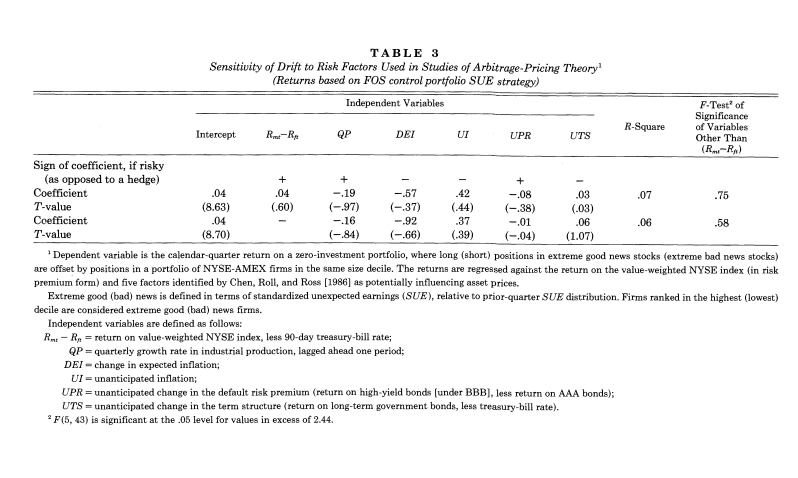

In [ ]:
#Extreme good news and bad news firms: generate 30-day Cumulative Abnormal returns with different method including date of data for table 3

main_df=cleaned_df
main_df_h_l=main_df[(main_df['sue_decile']==1)| (main_df['sue_decile']==10)]

#generate new dataframe with tic, SUE decile, and size decile on RDQ
tic_of_rdq_h_l=main_df_h_l.dropna()
tic_of_rdq_h_l=tic_of_rdq_h_l.filter(['tic', 'sue_decile', 'size_decile'])

#create new groupby variable of abnormal return with tic and original_index as indices
abn_ret_h_l=main_df_h_l.reset_index() #gen new index to pop out original one as 'index'
#rename 'index' to 'original_index' 
abn_ret_h_l.columns=['original_index', 'tic', 'date', 'datadate', 'year', 'qtr', 'ret', 'rdq', 'size_decile', 'avg_ret', 'abn_ret', 'sue', 'sue_decile']
abn_ret_h_l=abn_ret_h_l.groupby(['tic', 'original_index'], as_index=False)['abn_ret'].first()
abn_ret_h_l['new_index']=abn_ret_h_l['tic'].apply(str) + "/" + abn_ret_h_l['original_index'].apply(str)
abn_ret_h_l=abn_ret_h_l.set_index('new_index')

#create new df to store CAR around RDQ
car_30d_h_l=main_df.filter(['tic','date', 'sue_decile'])
car_30d_h_l['days_after_rdq']=""
car_30d_h_l['car']=""


car_60d_h_l=main_df.filter(['tic','date', 'sue_decile'])
car_60d_h_l['days_after_rdq']=""
car_60d_h_l['car']=""


In [ ]:
car_30d_h_l.index

In [ ]:
#calculate car and store in corresponding SUE deciles

n=30
for rdqdate in tic_of_rdq_h_l.index:
  rdqdateindex=str(tic_of_rdq_h_l['tic'][rdqdate]) + "/" + str(rdqdate)
  ndaysafterindex=str(tic_of_rdq_h_l['tic'][rdqdate]) + "/" + str(rdqdate + n)
  if ndaysafterindex in abn_ret_h_l.index: 
    after_df=pd.DataFrame(abn_ret.loc[rdqdateindex : ndaysafterindex]).reset_index()
    after_df['car']=after_df['abn_ret'].cumsum() - after_df['abn_ret'][0]
    car_30d_h_l['days_after_rdq'][rdqdate: rdqdate + n + 1]=after_df.index
    car_30d_h_l['car'][rdqdate : rdqdate + n + 1]=after_df['car']
    #car_30d_h_l.iloc[rdqdate : rdqdate + n + 1, car_30d_h_l.columns.get_loc('days_after_rdq')] = after_df.index
    #car_30d_h_l.iloc[rdqdate : rdqdate + n + 1, car_30d_h_l.columns.get_loc('car')] = after_df['car']


In [ ]:
n=60
for rdqdate in tic_of_rdq_h_l.index:
  rdqdateindex=str(tic_of_rdq_h_l['tic'][rdqdate]) + "/" + str(rdqdate)
  ndaysafterindex=str(tic_of_rdq_h_l['tic'][rdqdate]) + "/" + str(rdqdate + n)
  if ndaysafterindex in abn_ret_h_l.index: 
    after_df=pd.DataFrame(abn_ret.loc[rdqdateindex : ndaysafterindex]).reset_index()
    after_df['car']=after_df['abn_ret'].cumsum() - after_df['abn_ret'][0]
    #car_30d_h_l['days_after_rdq'][rdqdate: rdqdate + n + 1]=after_df.index
    #car_30d_h_l['car'][rdqdate : rdqdate + n + 1]=after_df['car']
    car_60d_h_l.iloc[rdqdate : rdqdate + n + 1, car_60d_h_l.columns.get_loc('days_after_rdq')] = after_df.index
    car_60d_h_l.iloc[rdqdate : rdqdate + n + 1, car_60d_h_l.columns.get_loc('car')] = after_df['car']


In [ ]:
car_30d_h_l['car'] *= 100
car_30d_h_l=car_30d_h_l[car_30d_h_l['days_after_rdq']==30]

car_60d_h_l['car'] *= 100
car_60d_h_l=car_60d_h_l[car_60d_h_l['days_after_rdq']==60]

print(car_30d_h_l)
print(car_60d_h_l)


In [ ]:
#replicate table 3 with 30d data

#import f-f-5 data
file=filepath + "F-F_Research_Data_5_Factors_2x3_daily.CSV"

ff_df=pd.read_csv(file, error_bad_lines=False)

print(ff_df)


In [ ]:
print(ff_df.columns)

In [ ]:
ff_df['Date']=pd.to_datetime(ff_df['Date'], format='%Y%m%d')
x=['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']

for x in x:
  ff_df[x]=pd.to_numeric(ff_df[x], errors='coerce')

#ad mkt column(not adjusted for treasury bills)

#rename columns
ff_df.columns=['date', 'rm_minus_rf', 'smb', 'hml', 'rmw', 'cma', 'rf', 'mkt']

#filter for after 2019
ff_df=ff_df[ff_df['date'] >= "2019-01-01"]

#left join ff into 30daytable

ff_df.to_sql("ff_df", conn, if_exists='replace')

car_30d_h_l.to_sql("car_30d_h_l", conn, if_exists='replace')

query=''' 
        SELECT DISTINCT car_30d_h_l.*, ff_df.smb, ff_df.hml, ff_df.raw, ff_df.cma, ff_df.rf, ff_df.mkt
        FROM car_30d_h_l
        LEFT JOIN ff_df
        ON car_30d_h_l.date=ff_df.date
        '''

car_30d_h_l_ff=pd.read_sql(query, conn)



# REPLICATE FIGURE 5 WITH 60D DATA

In [ ]:
#replicate figure 5

car_60d_h_l['year']=car_60d_h_l['date'].dt.year
car_60d_h_l['qtr']=np.ceil(car_60d_h_l['date'].dt.month/3)
car_60d_h_l['year/qtr']=car_60d_h_l['year'].apply(str) + "/" + car_60d_h_l['qtr'].apply(str)

car_60d_h_l=car_60d_h_l[car_60d_h_l['days_after_rdq']==60]
car_60d_gr=car_60d_h_l.groupby('year/qtr', as_index=False)['car'].mean()

plot_car_60d=car_60d_gr.plot(x='year/qtr', y=['car'], kind='bar', figsize=[15,10], title="Figure 5: CAR vs year/qtr of data")

fig=plot_car_60d.get_figure()

In [ ]:
break

# Replicate Table 4

In [ ]:
#Generate dataframes for each portfolio, for raw returns instead of CAR

main_df=cleaned_df

main_df_lo=main_df[main_df['sue_decile']==1]

main_df_lo_small=main_df_lo[main_df_lo['size_decile'] <= 4]
main_df_lo_med=main_df_lo[(main_df_lo['size_decile'] >= 5) & (main_df_lo['size_decile'] <= 7)]
main_df_lo_big=main_df_lo[main_df_lo['size_decile'] >= 8]

main_df_hi=main_df[main_df['sue_decile']==10]
main_df_hi_small=main_df_hi[main_df_hi['size_decile'] <= 4]
main_df_hi_med=main_df_hi[(main_df_hi['size_decile'] >= 5) & (main_df_hi['size_decile'] <= 7)]
main_df_hi_big=main_df_hi[main_df_hi['size_decile'] >= 8]



In [ ]:
print(main_df_lo)

In [ ]:
#S/L
tic_of_rdq_lo_small=main_df_lo_small.dropna()
tic_of_rdq_lo_small=tic_of_rdq_lo_small.filter(['tic', 'sue_decile', 'size_decile'])

raw_ret_lo_small=main_df.reset_index()
raw_ret_lo_small.columns=['original_index', 'tic', 'date', 'datadate', 'year', 'qtr', 'ret', 'rdq', 'size_decile', 'avg_ret', 'abn_ret', 'sue', 'sue_decile']
raw_ret_lo_small=raw_ret_lo_small.groupby(['tic', 'original_index'], as_index=False)['ret'].first()
raw_ret_lo_small['new_index']=raw_ret_lo_small['tic'].apply(str) + "/" + raw_ret_lo_small['original_index'].apply(str)
raw_ret_lo_small=raw_ret_lo_small.set_index('new_index')



In [ ]:
#m/l
tic_of_rdq_lo_med=main_df_lo_med.dropna()
tic_of_rdq_lo_med=tic_of_rdq_lo_med.filter(['tic', 'sue_decile', 'size_decile'])

raw_ret_lo_med=main_df.reset_index()
raw_ret_lo_med.columns=['original_index', 'tic', 'date', 'datadate', 'year', 'qtr', 'ret', 'rdq', 'size_decile', 'avg_ret', 'abn_ret', 'sue', 'sue_decile']
raw_ret_lo_med=raw_ret_lo_med.groupby(['tic', 'original_index'], as_index=False)['ret'].first()
raw_ret_lo_med['new_index']=raw_ret_lo_med['tic'].apply(str) + "/" + raw_ret_lo_med['original_index'].apply(str)
raw_ret_lo_med=raw_ret_lo_med.set_index('new_index')


In [ ]:
#b/l
tic_of_rdq_lo_big=main_df_lo_big.dropna()
tic_of_rdq_lo_big=tic_of_rdq_lo_big.filter(['tic', 'sue_decile', 'size_decile'])

raw_ret_lo_big=main_df.reset_index()
raw_ret_lo_big.columns=['original_index', 'tic', 'date', 'datadate', 'year', 'qtr', 'ret', 'rdq', 'size_decile', 'avg_ret', 'abn_ret', 'sue', 'sue_decile']
raw_ret_lo_big=raw_ret_lo_big.groupby(['tic', 'original_index'], as_index=False)['ret'].first()
raw_ret_lo_big['new_index']=raw_ret_lo_big['tic'].apply(str) + "/" + raw_ret_lo_big['original_index'].apply(str)
raw_ret_lo_big=raw_ret_lo_big.set_index('new_index')


In [ ]:
#s/h
tic_of_rdq_hi_small=main_df_hi_small.dropna()
tic_of_rdq_hi_small=tic_of_rdq_hi_small.filter(['tic', 'sue_decile', 'size_decile'])

raw_ret_hi_small=main_df.reset_index()
raw_ret_hi_small.columns=['original_index', 'tic', 'date', 'datadate', 'year', 'qtr', 'ret', 'rdq', 'size_decile', 'avg_ret', 'abn_ret', 'sue', 'sue_decile']
raw_ret_hi_small=raw_ret_hi_small.groupby(['tic', 'original_index'], as_index=False)['ret'].first()
raw_ret_hi_small['new_index']=raw_ret_hi_small['tic'].apply(str) + "/" + raw_ret_hi_small['original_index'].apply(str)
raw_ret_hi_small=raw_ret_hi_small.set_index('new_index')




In [ ]:
#m/h 

tic_of_rdq_hi_med=main_df_hi_med.dropna()
tic_of_rdq_hi_med=tic_of_rdq_hi_med.filter(['tic', 'sue_decile', 'size_decile'])

raw_ret_hi_med=main_df.reset_index()
raw_ret_hi_med.columns=['original_index', 'tic', 'date', 'datadate', 'year', 'qtr', 'ret', 'rdq', 'size_decile', 'avg_ret', 'abn_ret', 'sue', 'sue_decile']
raw_ret_hi_med=raw_ret_hi_med.groupby(['tic', 'original_index'], as_index=False)['ret'].first()
raw_ret_hi_med['new_index']=raw_ret_hi_med['tic'].apply(str) + "/" + raw_ret_hi_med['original_index'].apply(str)
raw_ret_hi_med=raw_ret_hi_med.set_index('new_index')


In [ ]:
#b/h
tic_of_rdq_hi_big=main_df_hi_big.dropna()
tic_of_rdq_hi_big=tic_of_rdq_hi_big.filter(['tic', 'sue_decile', 'size_decile'])

raw_ret_hi_big=main_df.reset_index()
raw_ret_hi_big.columns=['original_index', 'tic', 'date', 'datadate', 'year', 'qtr', 'ret', 'rdq', 'size_decile', 'avg_ret', 'abn_ret', 'sue', 'sue_decile']
raw_ret_hi_big=raw_ret_hi_big.groupby(['tic', 'original_index'], as_index=False)['ret'].first()
raw_ret_hi_big['new_index']=raw_ret_hi_big['tic'].apply(str) + "/" + raw_ret_hi_big['original_index'].apply(str)
raw_ret_hi_big=raw_ret_hi_big.set_index('new_index')



**S/L**

In [ ]:
#calculate raw returns (repeat for each segment)
 


startingdays=[1, 6, 21, 41, 61]
endingdays=[5, 20, 40, 60, 80]

avg_crr_lo_small=pd.DataFrame(index=startingdays, columns=['crr'])
for i in avg_crr_lo_small.index:
  for j in avg_crr_lo_small.columns:
    avg_crr_lo_small[j][i]=[]

print(avg_crr_lo_small)
#fill new df with cumulative raw return (CRR) data

for i in range(len(startingdays)):
  a=startingdays[i]
  b=endingdays[i]
  for rdqdate in tic_of_rdq_lo_small.index:
    startindex=str(tic_of_rdq_lo_small["tic"][rdqdate]) + "/" + str(rdqdate + a)
    endindex=str(tic_of_rdq_lo_small["tic"][rdqdate]) + "/" + str(rdqdate + b)
    if (startindex in raw_ret_lo_small.index) and (endindex in raw_ret_lo_small.index):
      period_df=pd.DataFrame(raw_ret_lo_small.loc[startindex : endindex]).reset_index()
      period_df['crr']=period_df['ret'].cumsum()
      avg_crr_lo_small['crr'][a].append(period_df['crr'][b-a])

for i in avg_crr_lo_small.index: 
  avg_crr_lo_small['crr'][i]=np.average(avg_crr_lo_small['crr'][i])*100
print(avg_crr_lo_small)

**M/L**

In [ ]:
#calculate raw returns-lo_med
 
startingdays=[1, 6, 21, 41, 61]
endingdays=[5, 20, 40, 60, 80]

avg_crr_lo_med=pd.DataFrame(index=startingdays, columns=['crr'])
for i in avg_crr_lo_med.index:
  for j in avg_crr_lo_med.columns:
    avg_crr_lo_med[j][i]=[]

print(avg_crr_lo_med)
#fill new df with cumulative raw return (CRR) data

for i in range(len(startingdays)):
  a=startingdays[i]
  b=endingdays[i]
  for rdqdate in tic_of_rdq_lo_med.index:
    startindex=str(tic_of_rdq_lo_med["tic"][rdqdate]) + "/" + str(rdqdate + a)
    endindex=str(tic_of_rdq_lo_med["tic"][rdqdate]) + "/" + str(rdqdate + b)
    if (startindex in raw_ret_lo_med.index) and (endindex in raw_ret_lo_med.index):
      period_df=pd.DataFrame(raw_ret_lo_med.loc[startindex : endindex]).reset_index()
      period_df['crr']=period_df['ret'].cumsum()
      
      avg_crr_lo_med['crr'][a].append(period_df['crr'][b-a])

for i in avg_crr_lo_med.index: 
  avg_crr_lo_med['crr'][i]=np.average(avg_crr_lo_med['crr'][i])*100
print(avg_crr_lo_med)


**H/L**

In [ ]:
#calculate raw returns -H/L
 
startingdays=[1, 6, 21, 41, 61]
endingdays=[5, 20, 40, 60, 80]

avg_crr_lo_big=pd.DataFrame(index=startingdays, columns=['crr'])
for i in avg_crr_lo_big.index:
  for j in avg_crr_lo_big.columns:
    avg_crr_lo_big[j][i]=[]

print(avg_crr_lo_big)
#fill new df with cumulative raw return (CRR) data

for i in range(len(startingdays)):
  a=startingdays[i]
  b=endingdays[i]
  for rdqdate in tic_of_rdq_lo_big.index:
    startindex=str(tic_of_rdq_lo_big["tic"][rdqdate]) + "/" + str(rdqdate + a)
    endindex=str(tic_of_rdq_lo_big["tic"][rdqdate]) + "/" + str(rdqdate + b)
    if (startindex in raw_ret_lo_big.index) and (endindex in raw_ret_lo_big.index):
      period_df=pd.DataFrame(raw_ret_lo_big.loc[startindex : endindex]).reset_index()
      period_df['crr']=period_df['ret'].cumsum()
      avg_crr_lo_big['crr'][a].append(period_df['crr'][b-a])

for i in avg_crr_lo_big.index: 
  avg_crr_lo_big['crr'][i]=np.average(avg_crr_lo_big['crr'][i])*100
print(avg_crr_lo_big)


**S/H**

In [ ]:
#S/H
startingdays=[1, 6, 21, 41, 61]
endingdays=[5, 20, 40, 60, 80]

avg_crr_hi_small=pd.DataFrame(index=startingdays, columns=['crr'])
for i in avg_crr_hi_small.index:
  for j in avg_crr_hi_small.columns:
    avg_crr_hi_small[j][i]=[]


#fill new df with cumulative raw return (CRR) data

for i in range(len(startingdays)):
  a=startingdays[i]
  b=endingdays[i]
  for rdqdate in tic_of_rdq_hi_small.index:
    startindex=str(tic_of_rdq_hi_small["tic"][rdqdate]) + "/" + str(rdqdate + a)
    endindex=str(tic_of_rdq_hi_small["tic"][rdqdate]) + "/" + str(rdqdate + b)
    if (startindex in raw_ret_hi_small.index) and (endindex in raw_ret_hi_small.index):
      period_df=pd.DataFrame(raw_ret_hi_small.loc[startindex : endindex]).reset_index()
      period_df['crr']=period_df['ret'].cumsum()
      avg_crr_hi_small['crr'][a].append(period_df['crr'][b-a])

for i in avg_crr_hi_small.index: 
  avg_crr_hi_small['crr'][i]=np.average(avg_crr_hi_small['crr'][i])*100
print(avg_crr_hi_small)

**M/H**

In [ ]:
startingdays=[1, 6, 21, 41, 61]
endingdays=[5, 20, 40, 60, 80]

avg_crr_hi_med=pd.DataFrame(index=startingdays, columns=['crr'])
for i in avg_crr_hi_med.index:
  for j in avg_crr_hi_med.columns:
    avg_crr_hi_med[j][i]=[]


#fill new df with cumulative raw return (CRR) data

for i in range(len(startingdays)):
  a=startingdays[i]
  b=endingdays[i]
  for rdqdate in tic_of_rdq_hi_med.index:
    startindex=str(tic_of_rdq_hi_med["tic"][rdqdate]) + "/" + str(rdqdate + a)
    endindex=str(tic_of_rdq_hi_med["tic"][rdqdate]) + "/" + str(rdqdate + b)
    if (startindex in raw_ret_hi_med.index) and (endindex in raw_ret_hi_med.index):
      period_df=pd.DataFrame(raw_ret_hi_med.loc[startindex : endindex]).reset_index()
      period_df['crr']=period_df['ret'].cumsum()
      avg_crr_hi_med['crr'][a].append(period_df['crr'][b-a])

for i in avg_crr_hi_med.index: 
  avg_crr_hi_med['crr'][i]=np.average(avg_crr_hi_med['crr'][i])*100
print(avg_crr_hi_med)

**H/H**

In [ ]:
startingdays=[1, 6, 21, 41, 61]
endingdays=[5, 20, 40, 60, 80]

avg_crr_hi_big=pd.DataFrame(index=startingdays, columns=['crr'])
for i in avg_crr_hi_big.index:
  for j in avg_crr_hi_big.columns:
    avg_crr_hi_big[j][i]=[]


#fill new df with cumulative raw return (CRR) data

for i in range(len(startingdays)):
  a=startingdays[i]
  b=endingdays[i]
  for rdqdate in tic_of_rdq_hi_big.index:
    startindex=str(tic_of_rdq_hi_big["tic"][rdqdate]) + "/" + str(rdqdate + a)
    endindex=str(tic_of_rdq_hi_big["tic"][rdqdate]) + "/" + str(rdqdate + b)
    if (startindex in raw_ret_hi_big.index) and (endindex in raw_ret_hi_big.index):
      period_df=pd.DataFrame(raw_ret_hi_big.loc[startindex : endindex]).reset_index()
      period_df['crr']=period_df['ret'].cumsum()
      avg_crr_hi_big['crr'][a].append(period_df['crr'][b-a])

for i in avg_crr_hi_big.index: 
  avg_crr_hi_big['crr'][i]=np.average(avg_crr_hi_big['crr'][i])*100
print(avg_crr_hi_big)

# PRODUCE CLEAN TABLE 4

In [ ]:
#table4a
table4a=pd.DataFrame(index=startingdays)
table4a["postannouncement_period"]=['(1/5)', '(6, 20)', '(21, 40)', '(41, 60)', '(61, 80)' ]

table4a['s/l_rr']=avg_crr_lo_small['crr']
table4a['s/l_crr']=table4a['s/l_rr'].cumsum()
table4a['m/l_rr']=avg_crr_lo_med['crr']
table4a['m/l_crr']=table4a['m/l_rr'].cumsum()
table4a['h/l_rr']=avg_crr_lo_big['crr']
table4a['h/l_crr']=table4a['h/l_rr'].cumsum()

print(table4a)

In [ ]:
#table 4b
table4b=pd.DataFrame(index=startingdays)
table4b["postannouncement_period"]=['(1/5)', '(6, 20)', '(21, 40)', '(41, 60)', '(61, 80)' ]

'''S/L'''
table4b['s/l_crr_anualized']=""
table4b['s/l_crr_anualized'][1]=table4a['s/l_crr'][1] * 252/5
table4b['s/l_crr_anualized'][6]=table4a['s/l_crr'][6] * 252/20
table4b['s/l_crr_anualized'][21]=table4a['s/l_crr'][21] * 252/40
table4b['s/l_crr_anualized'][41]=table4a['s/l_crr'][41] * 252/60
table4b['s/l_crr_anualized'][61]=table4a['s/l_crr'][61] * 252/80

'''m/l'''
table4b['m/l_crr_anualized']=""
table4b['m/l_crr_anualized'][1]=table4a['m/l_crr'][1] * 252/5
table4b['m/l_crr_anualized'][6]=table4a['m/l_crr'][6] * 252/20
table4b['m/l_crr_anualized'][21]=table4a['m/l_crr'][21] * 252/40
table4b['m/l_crr_anualized'][41]=table4a['m/l_crr'][41] * 252/60
table4b['m/l_crr_anualized'][61]=table4a['m/l_crr'][61] * 252/80

'''h/l'''
table4b['h/l_crr_anualized']=""
table4b['h/l_crr_anualized'][1]=table4a['h/l_crr'][1] * 252/5
table4b['h/l_crr_anualized'][6]=table4a['h/l_crr'][6] * 252/20
table4b['h/l_crr_anualized'][21]=table4a['h/l_crr'][21] * 252/40
table4b['h/l_crr_anualized'][41]=table4a['h/l_crr'][41] * 252/60
table4b['h/l_crr_anualized'][61]=table4a['h/l_crr'][61] * 252/80



In [ ]:
#table 4b continued

'''s/h'''
table4b['s/h_crr_anualized']=""
table4b['s/h_crr_anualized']=avg_crr_hi_small.cumsum()
table4b['s/h_crr_anualized'][1]*=252/5
table4b['s/h_crr_anualized'][6]*=252/20
table4b['s/h_crr_anualized'][21]*=252/40
table4b['s/h_crr_anualized'][41]*=252/60
table4b['s/h_crr_anualized'][61]*=252/80

'''m/h'''
table4b['m/h_crr_anualized']=""
table4b['m/h_crr_anualized']=avg_crr_hi_med.cumsum()
table4b['m/h_crr_anualized'][1]*=252/5
table4b['m/h_crr_anualized'][6]*=252/20
table4b['m/h_crr_anualized'][21]*=252/40
table4b['m/h_crr_anualized'][41]*=252/60
table4b['m/h_crr_anualized'][61]*=252/80


'''h/h'''
table4b['h/h_crr_anualized']=""
table4b['h/h_crr_anualized']=avg_crr_hi_small.cumsum()
table4b['h/h_crr_anualized'][1]*=252/5
table4b['h/h_crr_anualized'][6]*=252/20
table4b['h/h_crr_anualized'][21]*=252/40
table4b['h/h_crr_anualized'][41]*=252/60
table4b['h/h_crr_anualized'][61]*=252/80



In [ ]:
print(table4b)